# 梯度消失vs梯度爆炸

refs:

[详解机器学习中的梯度消失、爆炸原因及其解决方法](https://blog.csdn.net/qq_25737169/article/details/78847691)

[经网络训练中的梯度消失与梯度爆炸](https://zhuanlan.zhihu.com/p/25631496)

[误差反向传播（BP）算法中为什么会产生梯度消失？](https://www.zhihu.com/question/49812013)

[LSTM如何来避免梯度弥散和梯度爆炸？](https://www.zhihu.com/question/34878706/answer/152555959)

[机器学习总结（九）：梯度消失（vanishing gradient）与梯度爆炸（exploding gradient）问题](https://blog.csdn.net/cppjava_/article/details/68941436)

[梯度消失和梯度爆炸问题详解](https://www.jianshu.com/p/3f35e555d5ba)

[深度学习中的梯度消失](https://www.cnblogs.com/maybe2030/p/6336896.html#top)
[梯度消失问题与如何选择激活函数](https://zhuanlan.zhihu.com/p/40092847)

## 原因

简单地说，**根据链式法则**，**在梯度反向传播过程中**，
+ 如果每一层神经元对上一层的输出的偏导乘上权重结果都小于1的话，那么即使这个结果是0.99，在经过足够多层梯度反向传播之后，误差对输入层的偏导会趋于0；
+ 如果每一层神经元对上一层的输出的偏导乘上权重结果都大于１的话，那么即使这个结果是1.01，在经过足够多层梯度反向传播之后，误差对输入层的偏导会趋于无穷大。
sigmoid和tanh激活函数：
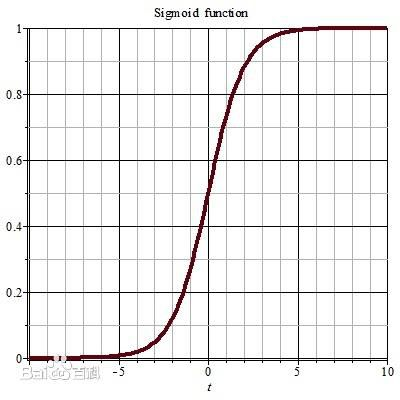
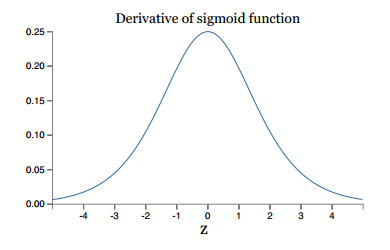
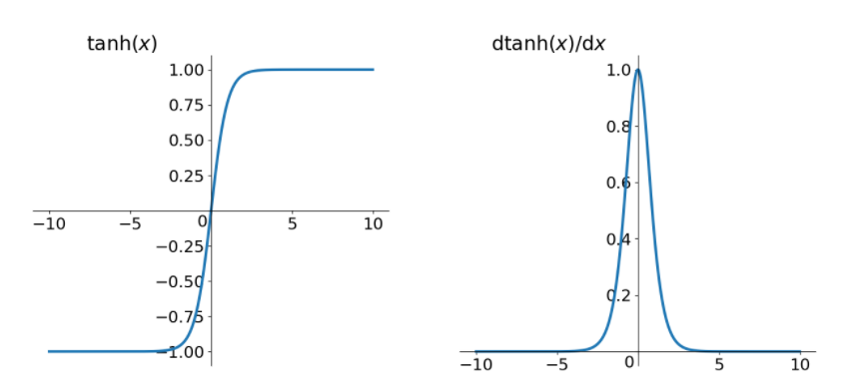

## 解决办法

### 预训练加微调
此方法来自Hinton在2006年发表的一篇论文，Hinton为了解决梯度的问题，**提出采取无监督逐层训练方法**，**其基本思想是每次训练一层隐节点，训练时将上一层隐节点的输出作为输入，而本层隐节点的输出作为下一层隐节点的输入，此过程就是逐层“预训练”（pre-training）；在预训练完成后，再对整个网络进行“微调”（fine-tunning）**。Hinton在训练深度信念网络（Deep Belief Networks中，使用了这个方法，在各层预训练完成后，再利用BP算法对整个网络进行训练。此思想相当于是先寻找局部最优，然后整合起来寻找全局最优，**此方法有一定的好处，但是目前应用的不是很多了**。

### 梯度剪切、正则
**梯度剪切这个方案主要是针对梯度爆炸提出的**，**其思想是设置一个梯度剪切阈值，然后更新梯度的时候，如果梯度超过这个阈值，那么就将其强制限制在这个范围之内。这可以防止梯度爆炸**。

注：在WGAN中也有梯度剪切限制操作，但是和这个是不一样的，WGAN限制梯度更新信息是为了保证lipchitz条件。
另外一种解决梯度爆炸的手段是采用权重正则化（weithts regularization）比较常见的是l1正则，和l2正则，在各个深度框架中都有相应的API可以使用正则化，比如在tensorflow中，若搭建网络的时候已经设置了正则化参数，则调用以下代码可以直接计算出正则损失：

regularization_loss = tf.add_n(tf.losses.get_regularization_losses(scope='my_resnet_50'))

如果没有设置初始化参数，也可以使用以下代码计算l2正则损失：

l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables() if 'weights' in var.name])

正则化是通过对网络权重做正则限制过拟合，仔细看正则项在损失函数的形式：

Loss = (y - W<sup>T</sup>x)<sup>2</sup> + $\alpha$||W||<sup>2</sup>

其中，$\alpha$是指正则项系数，因此，如果发生梯度爆炸，权值的范数就会变的非常大，通过正则化项，可以部分限制梯度爆炸的发生。

注：事实上，在深度神经网络中，往往是梯度消失出现的更多一些。

### relu、leakrelu、elu等激活函数
#### relu
**Relu思想也很简单，如果激活函数的导数为1，那么就不存在梯度消失爆炸的问题了**，每层的网络都可以得到相同的更新速度，relu就这样应运而生。先看一下relu的数学表达式：
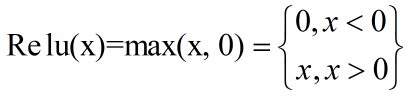
其函数图像：
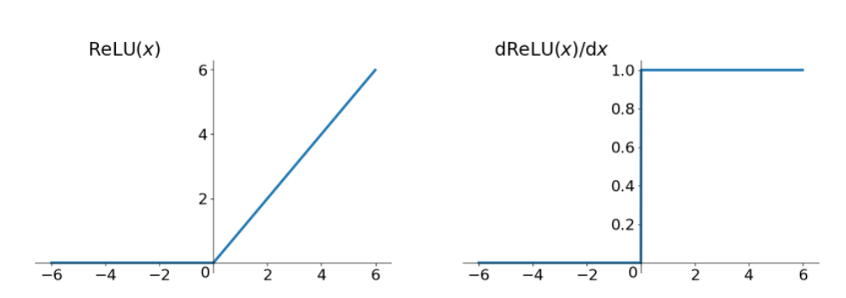
从上图中，我们可以很容易看出，relu函数的导数在正数部分是恒等于1的，因此在深层网络中使用relu激活函数就不会导致梯度消失和爆炸的问题。

relu的主要贡献在于：
+ 解决了梯度消失、爆炸的问题
+ 计算方便，计算速度快
+ 加速了网络的训练

同时也存在一些缺点：

+ 由于负数部分恒为0，会导致一些神经元无法激活（可通过设置小学习率部分解决）
+ 输出不是以0为中心的

尽管relu也有缺点，但是仍然是目前使用最多的激活函数

#### leakrelu
leakrelu就是为了解决relu的0区间带来的影响，其数学表达为：leak_relu = max(k*x, x),其中k是leak系数，一般选择0.01或者0.02，或者通过学习而来
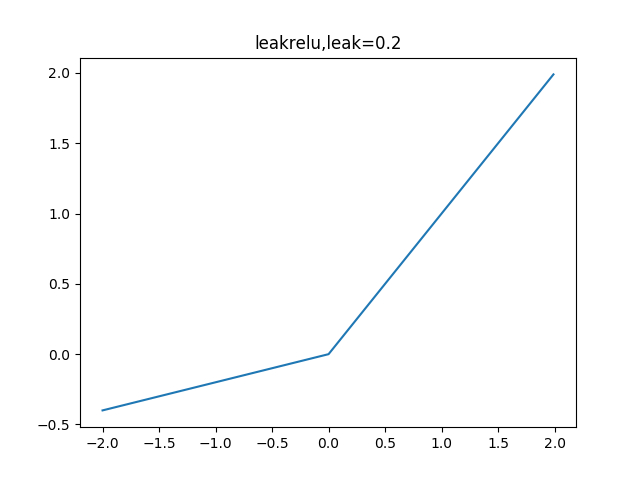
leakrelu解决了0区间带来的影响，而且包含了relu的所有优点
#### elu
elu激活函数也是为了解决relu的0区间带来的影响，其数学表达为：
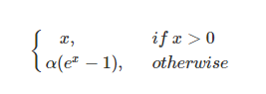
其函数及其导数数学形式为：
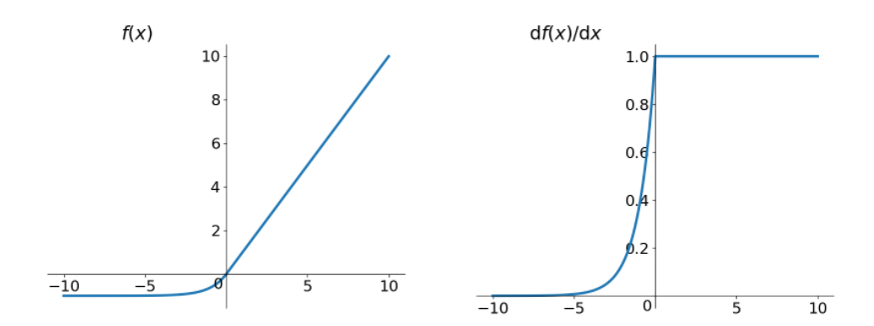
但是elu相对于leakrelu来说，计算要更耗时间一些。

### batchnorm
**Batchnorm是深度学习发展以来提出的最重要的成果之一了**，目前已经被广泛的应用到了各大网络中，**具有加速网络收敛速度**，**提升训练稳定性的效果**，**Batchnorm本质上是解决反向传播过程中的梯度问题**。batchnorm全名是batch normalization，简称BN，即批规范化，通过规范化操作将输出信号x规范化保证网络的稳定性。
具体的batchnorm原理非常复杂，在这里不做详细展开，此部分大概讲一下batchnorm解决梯度的问题上。具体来说就是反向传播中，经过每一层的梯度会乘以该层的权重，举个简单例子：
正向传播中f<sub>2</sub> = f<sub>1</sub>(W<sup>T</sup>*x+b)，那么反向传播中，$\frac{\Delta f_2}{\Delta w} = \frac{\Delta f_2}{\Delta f_1}*x$，反向传播式子中有x的存在，所以x的大小影响了梯度的消失和爆炸，batchnorm就是通过对每一层的输出规范为均值和方差一致的方法，消除了x带来的放大缩小的影响，进而解决梯度消失和爆炸的问题，或者可以理解为BN将输出从饱和区拉倒了非饱和区。
有关batch norm详细的内容可以参考我的另一篇博客：
http://blog.csdn.net/qq_25737169/article/details/79048516

### 残差结构
残差结构说起残差的话，不得不提这篇论文了：Deep Residual Learning for Image Recognition，关于这篇论文的解读，可以参考知乎链接：https://zhuanlan.zhihu.com/p/31852747这里只简单介绍残差如何解决梯度的问题。
事实上，就是残差网络的出现导致了image net比赛的终结，自从残差提出后，几乎所有的深度网络都离不开残差的身影，相比较之前的几层，几十层的深度网络，在残差网络面前都不值一提，残差可以很轻松的构建几百层，一千多层的网络而不用担心梯度消失过快的问题，原因就在于残差的捷径（shortcut）部分，其中残差单元如下图所示：
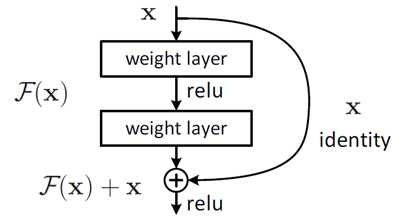
相比较于以前网络的直来直去结构，残差中有很多这样的跨层连接结构，这样的结构在反向传播中具有很大的好处，见下式：
式子的第一个因子$\frac{\Delta loss}{\Delta x_l}$	
  表示的损失函数到达 L 的梯度，小括号中的1表明短路机制可以无损地传播梯度，而另外一项残差梯度则需要经过带有weights的层，梯度不是直接传递过来的。残差梯度不会那么巧全为-1，而且就算其比较小，有1的存在也不会导致梯度消失。所以残差学习会更容易。

注：上面的推导并不是严格的证明。

### LSTM
LSTM全称是长短期记忆网络（long-short term memory networks），是不那么容易发生梯度消失的，**主要原因在于LSTM内部复杂的“门”(gates)**，如下图，LSTM通过它内部的“门”可以接下来更新的时候“记住”前几次训练的”残留记忆“，因此，经常用于生成文本中。目前也有基于CNN的LSTM，感兴趣的可以尝试一下。